In [1]:
import matplotlib.gridspec as gs
import matplotlib.pyplot as pp
import pandas as pd
import pingouin as pg
import seaborn as sb

from pandas.api.types import CategoricalDtype

In [2]:
def format_p_val(p):
    """Given a p-value format it to a nice string.

    Examples:
        format_p_val(0.43242323) -> p = 0.432
        format_p_val(0.000001) -> p < 0.001
    """
    if p < 0.001:
        return "p < 0.001"
    else:
        return "p = {}".format(round(p, 3))

First let's load the dataset and set the columns to the appropriate type.

Key point is to set the categorical/ordinal columns using the `astype` method and the `CategoricalDtype` class.

### Loading the data

In [3]:
# Read the data
file_name = "../data/mouse_linear_regression.csv"
df = pd.read_csv(file_name)
# Set relevant variables to categorical/ordinal with appropriate levels and order
df["Genotype"] = df["Genotype"].astype(
    CategoricalDtype(categories=["WT", "-/-"], ordered=True)
)
df["Sex"] = df["Sex"].astype(CategoricalDtype(categories=["F", "M"], ordered=False))
df["Treatment group"] = df["Treatment group"].astype(
    CategoricalDtype(categories=["Control", "TX", "TX2"], ordered=True)
)
# Take a look a the data
df.head()

,Baseline weight,Weight,Treatment group,Genotype,Sex
0,54.468602,53.450169,Control,WT,M
1,50.661773,51.595493,Control,WT,M
2,51.960877,52.870334,Control,WT,M
3,48.236403,48.150939,Control,WT,M
4,49.067158,49.253511,Control,WT,M


### Exploratory data analysis

Now let's take a quick look at the data.
Here we use the seaborn [`catplot`](https://seaborn.pydata.org/generated/seaborn.catplot.html) function which allows us to create panelled plots for categorical data.
There are various types of plot supported throught the `kind` argument.

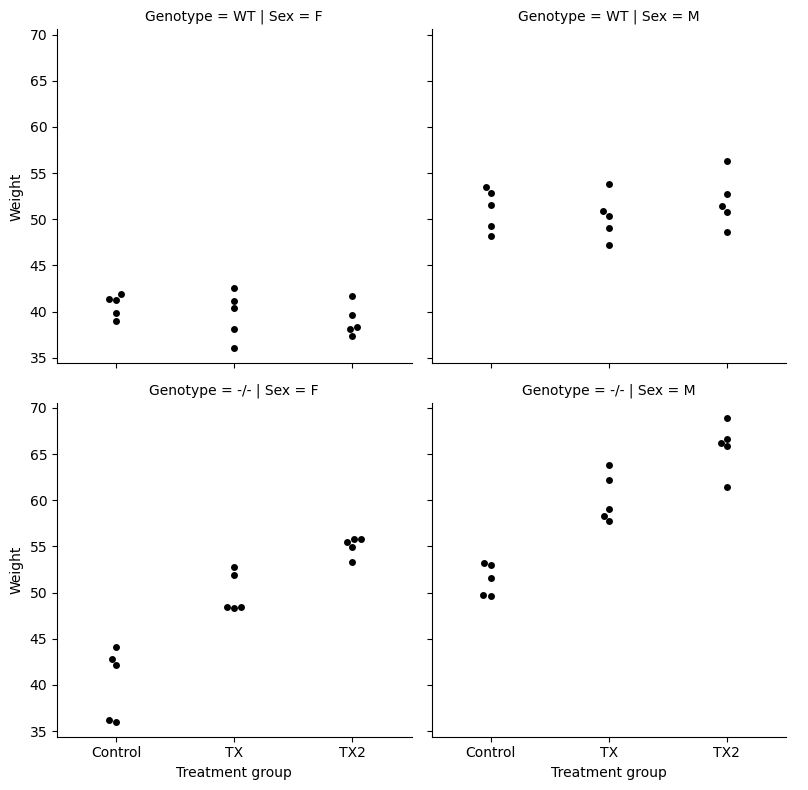

In [4]:
sb.catplot(
    df,
    kind="swarm",
    col="Sex",
    row="Genotype",
    x="Treatment group",
    y="Weight",
    color="k",
    aspect=1, # Width to height ratio
    height=4, # Height
)

The `catplot` function is useful for quickly getting a look at the data, but lacks flexibility if we want to combine different types of plots.
Previously we had seen how could use the `pointplot` and `swarmplot` functions to data plots with errors bars.
One way to do this is to use the [plotnine](https://plotnine.org) package which attempts to mimic R's ggplot library.
I prefer to use [matplotlib](https://matplotlib.org) along with seaborn.
It is a steeper learning curve, but ultimately gives a lot more control.

The key idea below is to use the `GridSpec` class which allows us to create a grid of `Axes` object.
`GridSpec` really only lays out the positions of the boxes for the `Axes`, to create them we first create a `Figure` object and then create `Axes` in the relevant location using `add_subplot`.

> Note: The `tight_layout` method is really useful for getting the `Axes` to be nicely spaced.

In [5]:
# Start by defining which columns we need for the plot
col = "Sex"
row = "Genotype"
x = "Treatment group"
y = "Weight"

In [6]:
# Now we need to find out how many rows and columns we need.
# To do so we just ask how many unique values are present in the relevant columns of our dataset.
ncols = df[col].nunique()
nrows = df[row].nunique()

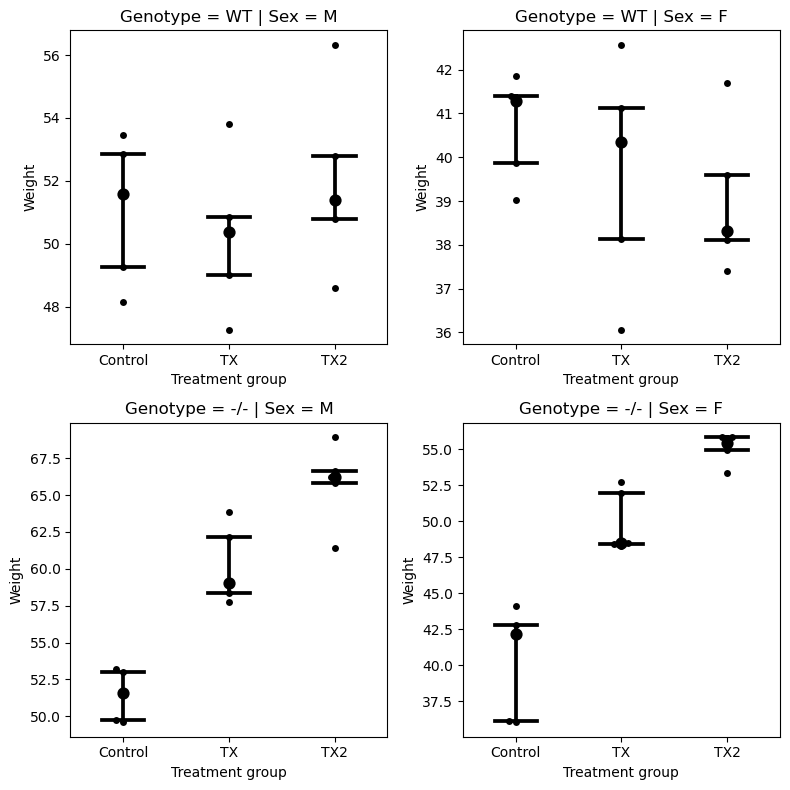

In [7]:
# Create the grid and do our plotting
grid = gs.GridSpec(nrows=nrows, ncols=ncols)
# Create a figure to plot to
fig = pp.figure(figsize=(8, 8))
# Now we loop through the different row and column values to create our plots
for i, row_val in enumerate(df[row].unique()):
    for j, col_val in enumerate(df[col].unique()):
        # Create an Axes object for plotting
        ax = fig.add_subplot(grid[i, j])
        # Subset our DataFrame to the relevant entries
        plot_df = df[(df[row] == row_val) & (df[col] == col_val)]
        # Now we can plot using the code from worksheet 2
        sb.swarmplot(
            plot_df,
            ax=ax,
            x=x,
            y=y,
            color="k",
        )
        sb.pointplot(
            plot_df,
            ax=ax,
            x=x,
            y=y,
            capsize=0.4,
            color="k",
            estimator="median",
            errorbar=("pi", 50),
            linestyle="none",
        )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title("Genotype = {0} | Sex = {1}".format(row_val, col_val))
# Usually a good idea to do tight_layout
grid.tight_layout(fig)

### Testing difference of means

Our EDA has revealed that genotype -/- seems to have an interaction with the treatment, whereas the WT genotype doesn't seem to be impacted by treatment.
To start with let's split the data by genotype and test the difference of means.

In [8]:
# Subset by genotype
df_geno = df[df["Genotype"] == "WT"]
# Create one group for control
x = df_geno.loc[df_geno["Treatment group"] == "Control", "Weight"]
# Create another group for single treatment
y = df_geno.loc[df_geno["Treatment group"] == "TX", "Weight"]
# Use pingouin to do a t test
pg.ttest(x, y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.34937,18,two-sided,0.730865,"[-4.63, 6.47]",0.156243,0.415,0.062653


As expected, no effect for the WT genotype.
Let's try for the knockout genotype.

In [9]:
# Subset by genotype
df_geno = df[df["Genotype"] == "-/-"]
# Create one group for control
x = df_geno.loc[df_geno["Treatment group"] == "Control", "Weight"]
# Create another group for single treatment
y = df_geno.loc[df_geno["Treatment group"] == "TX", "Weight"]
# Use pingouin to do a t test
pg.ttest(x, y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.339284,18,two-sided,0.00365,"[-15.09, -3.43]",1.493373,10.969,0.884271


Now we see an effect.
We should conduct our assumptions check on the data.
Here we will do Shapiro-Wilks for normality and Levene's test for equal variance of the populations.

In [10]:
# Shapiro-Wilks
pg.normality(
    data=df_geno,
    dv="Weight",
    group="Treatment group"
)

,W,pval,normal
Treatment group,,,
Control,0.890315,0.170968,True
TX,0.899436,0.215991,True
TX2,0.850866,0.059484,True


In [11]:
# Levene's test
pg.homoscedasticity(
    data=df_geno,
    dv="Weight",
    group="Treatment group"
)

,W,pval,equal_var
levene,0.075606,0.927377,True


Normality and equal variance hold.
So far this looks like a lot more work than JASP.
The benefit comes if we want to do a few different comparisons.
We can reuse the previous code but put it inside a `for` loop.

In [12]:
# We will split by the genotypes
genos = ["-/-", "WT"]
# We will save our results in a list
results = []
# Now we loop over the genotypes
for g in genos:
    # Do the t test
    df_g = pg.pairwise_tests(
        data=df[df["Genotype"] == g],
        dv="Weight",
        between="Treatment group"
    )
    # Add the information about which genotype we looked at to the data frame
    df_g.insert(0, "Genotype", g)
    # Add the genotype results to our results list
    results.append(df_g)
# Turn our results into a dataframe by concatenating them
results = pd.concat(results)
results

,Genotype,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,-/-,Treatment group,Control,TX,False,True,-3.339284,18.0,two-sided,0.003650,10.969,-1.430273
1,-/-,Treatment group,Control,TX2,False,True,-5.218810,18.0,two-sided,0.000058,312.592,-2.235306
2,-/-,Treatment group,TX,TX2,False,True,-2.020861,18.0,two-sided,0.058425,1.537,-0.865570
0,WT,Treatment group,Control,TX,False,True,0.349370,18.0,two-sided,0.730865,0.415,0.149641
1,WT,Treatment group,Control,TX2,False,True,0.129879,18.0,two-sided,0.898102,0.4,0.055629
2,WT,Treatment group,TX,TX2,False,True,-0.183383,18.0,two-sided,0.856548,0.402,-0.078546


Now we should also be doing multiple test correction on the p-values.
The `statsmodels` (imported as `sm`) package provides support for this.
Below I will use Bonferroni to adjust the p-values and Benjamini/Hochberg to get the false discovery rate.

In [17]:
pg.multicomp(results["p-unc"], method="bonferroni")

(array([ True,  True, False, False, False, False]),
 array([2.19023790e-02, 3.47759591e-04, 3.50552124e-01, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00]))

The `multicomp` function that corrects for multiple testing returns to collections of things.

1. Whether the corrected values are reject the null at a given power (0.05) by default.
2. The adjusted p-values.

If we just want the p-values we can select them using the indexing notation `[1]` since they are the second element. 
> Recall that Python uses zero-based indexing i.e. starts counting from zero.

In [13]:
results["p_bon"] = pg.multicomp(results["p-unc"], method="bonferroni")[1]
results["fdr"] = pg.multicomp(results["p-unc"], method="fdr_bh")[1]
results

,Genotype,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges,p_bon,fdr
0,-/-,Treatment group,Control,TX,False,True,-3.339284,18.0,two-sided,0.003650,10.969,-1.430273,0.021902,0.010951
1,-/-,Treatment group,Control,TX2,False,True,-5.218810,18.0,two-sided,0.000058,312.592,-2.235306,0.000348,0.000348
2,-/-,Treatment group,TX,TX2,False,True,-2.020861,18.0,two-sided,0.058425,1.537,-0.865570,0.350552,0.116851
0,WT,Treatment group,Control,TX,False,True,0.349370,18.0,two-sided,0.730865,0.415,0.149641,1.000000,0.898102
1,WT,Treatment group,Control,TX2,False,True,0.129879,18.0,two-sided,0.898102,0.4,0.055629,1.000000,0.898102
2,WT,Treatment group,TX,TX2,False,True,-0.183383,18.0,two-sided,0.856548,0.402,-0.078546,1.000000,0.898102


If the normality tests had failed we could also perform Mann Whitney.

> Caveat: scipy does not seem to support CI's for Mann Whitney.

In [14]:
df_geno = df[df["Genotype"] == "-/-"]
# Mann Whitney
pg.pairwise_tests(
    data=df_geno,
    dv="Weight",
    between="Treatment group",
    parametric=False
)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,Treatment group,Control,TX,False,False,19.0,two-sided,0.021134,-1.430273
1,Treatment group,Control,TX2,False,False,0.0,two-sided,0.000183,-2.235306
2,Treatment group,TX,TX2,False,False,27.0,two-sided,0.088973,-0.865570


If the equal variance test fails we use Welch's t test.

In [15]:
df_geno = df[df["Genotype"] == "-/-"]
# Mann Whitney
pg.pairwise_tests(
    data=df_geno,
    dv="Weight",
    between="Treatment group",
    correction=True
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Treatment group,Control,TX,False,True,-3.339284,17.790898,two-sided,0.003697,10.969,-1.430273
1,Treatment group,Control,TX2,False,True,-5.218810,17.861446,two-sided,0.000059,312.592,-2.235306
2,Treatment group,TX,TX2,False,True,-2.020861,17.992414,two-sided,0.058432,1.537,-0.865570
